### Imports

In [1]:
import pickle
from connections.mysql_connector import MySQL_Connector
from models.topic_modeling import Topic_Modeling
from connections.neo4j_connector import Neo4j_Connector
import os
from datetime import datetime
from gensim import corpora, models, similarities
from models.graph_generator import Graph_Generator
from models.tuple_extractor import Tuple_Extractor
from acessos import read, get_conn, persistir_uma_linha, persistir_multiplas_linhas, replace_df, update_banco
import pandas as pd
import re
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.parsing.preprocessing import strip_punctuation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
from tqdm.auto import tqdm  # for notebooks
import math

In [2]:
def contar_tokens(texto):
    doc = nlp(texto)
    num_token = 0
    for token in doc:
        if token.pos_ != "SPACE":
            num_token = num_token + 1
    return num_token

def get_textos(table_name, text_column, id_column):
    query =  "SELECT {}, {} FROM {}".format(id_column, text_column, table_name)
    return read(conn, query)

### Inicializando Parâmetros

In [3]:
nlp = spacy.load('pt_core_news_lg')
connector = MySQL_Connector("conn_orfeu")
db_name = "flairs2"
conn = connector.return_conn(db_name)


### Processando Contagem de Tokens

In [4]:
list_tables = ["video", "sentencas", "tuplas"]
dict_table = {"video": ["video_id", "transcription"],
              "sentencas": ["sentenca_id", "sentenca"],
              "tuplas": ["tupla_id", "tupla_completa"]
             }


for table in list_tables:
    id_column = dict_table[table] [0]
    text_column = dict_table[table][1]
    persist_table = "{}_tokens".format(table)
    
    df_textos = get_textos(table, text_column, id_column)
    df_textos["num_tokens"] = df_textos.apply(lambda x: contar_tokens(x[text_column]) ,axis=1)
    df_tokens = df_textos[[id_column, 'num_tokens']]
    replace_df(df_tokens, persist_table, conn)

Iniciando Persistencia
Sucesso na inserção
Iniciando Persistencia
Sucesso na inserção
Iniciando Persistencia
Sucesso na inserção


# Gerando histogramas Videos

array([[<AxesSubplot:title={'center':'num_tokens'}>]], dtype=object)

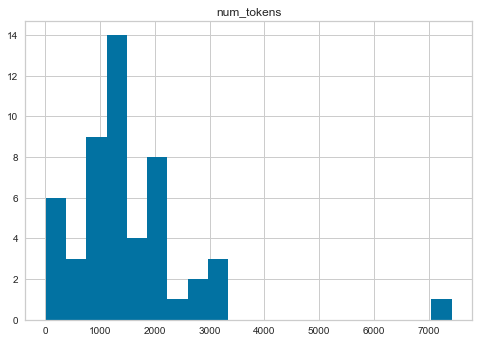

In [20]:
query = "SELECT video_id, num_tokens FROM  video INNER JOIN video_tokens USING(video_id);"
df_video = read(conn, query)
df_video.hist(bins=20)


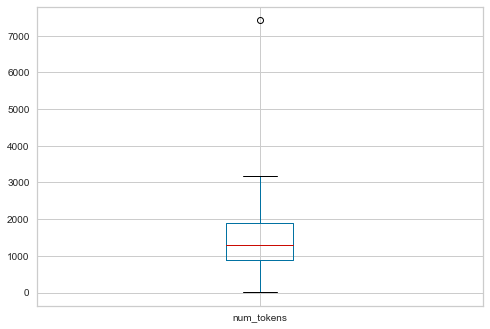

In [21]:
df_video.boxplot(column='num_tokens', return_type='axes');

# Sentencas 

<AxesSubplot:>

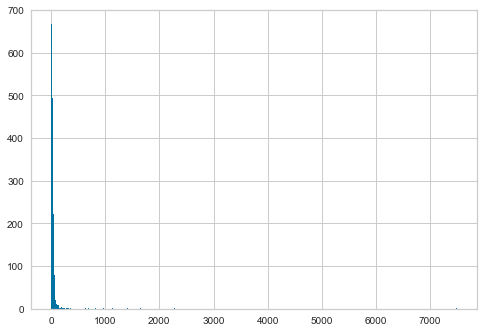

In [18]:
query = "SELECT * FROM sentencas INNER JOIN sentencas_tokens USING (sentenca_id)"
df_sentencas = read(conn, query)
df_sentencas['num_tokens'].hist(bins=500)

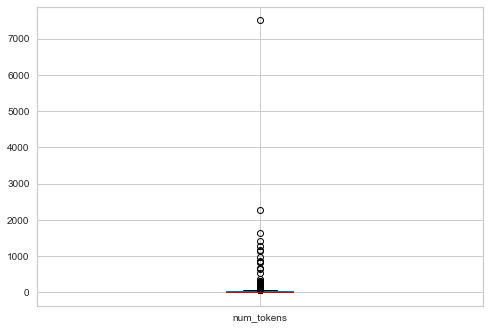

In [22]:
df_sentencas.boxplot(column='num_tokens', return_type='axes');

# Tuplas 

<AxesSubplot:>

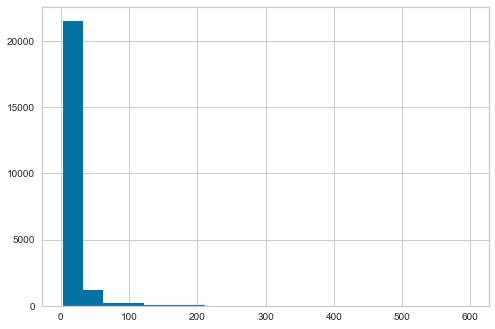

In [25]:
query = "SELECT tupla_id, sentenca_id, video_id, tupla_completa, num_tokens FROM tuplas INNER JOIN tuplas_tokens USING (tupla_id)"
df_tupla = read(conn, query)
df_tupla['num_tokens'].hist(bins=20)